# Digit Recognizer(Kaggle Competition)

## To Do
* Read Keras implemented models


# Contents
* Preconfiguration
* Preprocessing
   * Loading Images
   * Transformation & Labeling
   * Checking For Balance Data
   * Shuffling
   * Train/Validation Split
   * Remove Outliers 
   * Remove Equal Images
   * Normalization
   * Augmentation
   * One Hot Encoding Labels
* Models
    * simple NN
    * simple CNN
    * LeNet
    * GoogLeNet
    * ResNet
* Training
* Evaluation

## Preconfiguration

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Model
import keras as K
from skimage.measure import compare_ssim as ssim
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, MaxPooling2D, Input, Dense, Flatten, AveragePooling2D, Dropout
from keras.layers import LeakyReLU,PReLU
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from models.googlenet.inception_v4 import conv_block,inception_A

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\envs\deeplearning\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
data_root = 'data'
models_root = 'saved_models'
train_file = os.path.join(data_root,'train.csv')
test_file = os.path.join(data_root,'test.csv')
test_label_file = os.path.join(data_root,'sample_submission.csv')
img_shape = (28,28)

## Preprocessing

### Loading Images

In [3]:
tmp_train = pd.read_csv(train_file)
tmp_test = pd.read_csv(test_file)

In [4]:
tmp_train.sample(5)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
18637,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14578,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32190,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21443,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22988,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
tmp_test.head(5)

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Transformation & Labeling

In [6]:
def tranfrom_to_image_shape(data,shape) :
    data = np.array(data)
    img_data = np.ndarray((data.shape[0],shape[0],shape[1]))
    for i,img in enumerate(data) :
        for j,pixel in enumerate(img) :
            img_data[i,int(j/shape[0]),int(j%shape[1])] = pixel
    return img_data
tmp_img_train = tranfrom_to_image_shape(tmp_train.drop('label',axis=1),img_shape)
tmp_img_test = tranfrom_to_image_shape(tmp_test,img_shape)
labels = tmp_train['label']

Making Sure That transformation and labeling are working fine

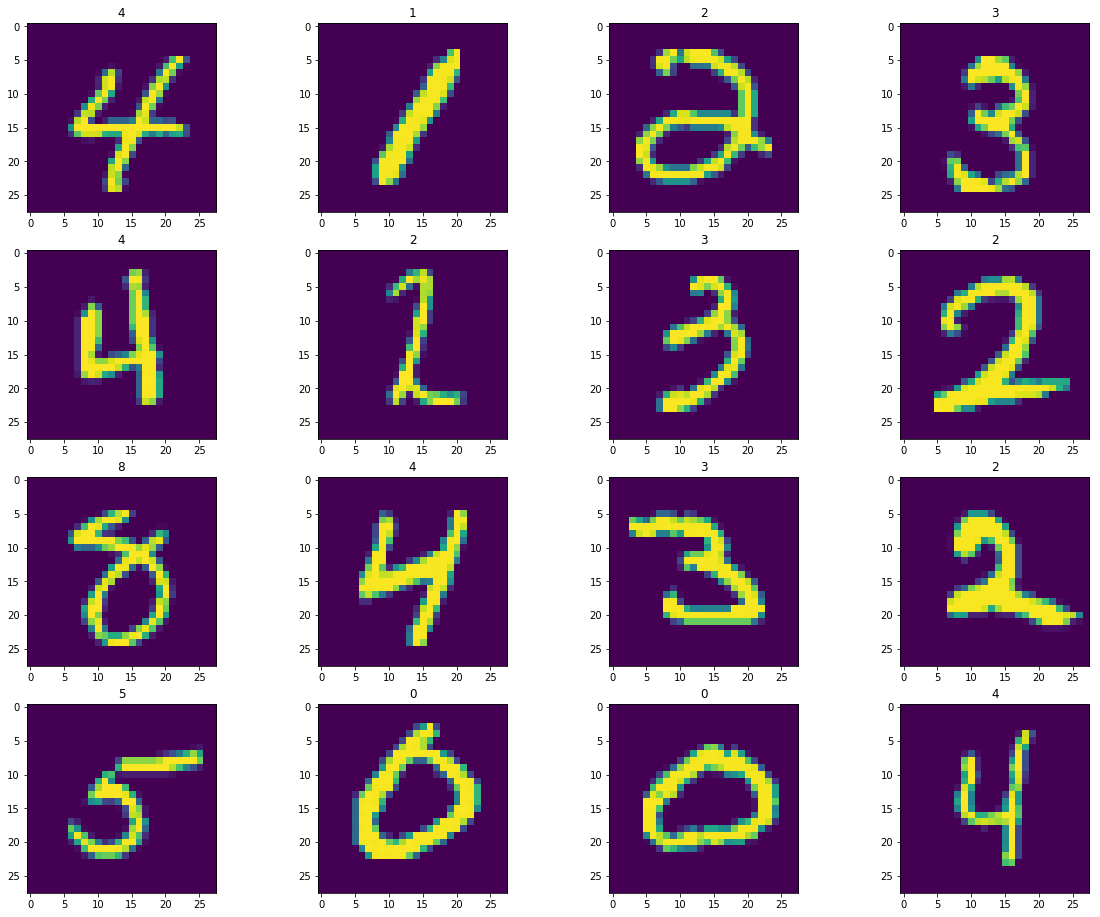

In [7]:
def img_random_visualization(imgs,labels) :
    f,ax = plt.subplots(4,4,figsize=(20,16))
    for i in ax :
        for j in i :
            rnd = np.random.randint(imgs.shape[0])
            j.set_title(labels[rnd])
            j.imshow(imgs[rnd])
img_random_visualization(tmp_img_train,labels)

### Checking For Balance Data

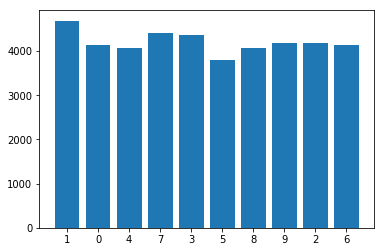

In [8]:
def hist_calc(arr) :
    dic = {}
    for i in arr :
        if i in dic :
            dic[i] += 1
        else :
            dic[i] = 1
    return dic

def hist_visualizer(dic) :
    plt.bar(range(len(dic)), list(dic.values()), align='center')
    plt.xticks(range(len(dic)), list(dic.keys()))
    plt.show()

hist_visualizer(hist_calc(labels))

As you see data is nearly balanced.

### Shuffling

In [9]:
def shuffle_dataset(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation,:,:]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels
tmp_img_train,labels = shuffle_dataset(tmp_img_train,labels)

### Train/Validation Split

In [10]:
X_train, X_valid, y_train, y_valid = train_test_split(tmp_img_train, labels, test_size=.15)
print('train dataset shape : {} \ntrain label shape : {} \nvalidation dataset shape : {} \nvalidation label shape : {}'.format(X_train.shape,y_train.shape,X_valid.shape,y_valid.shape))

train dataset shape : (35700, 28, 28) 
train label shape : (35700,) 
validation dataset shape : (6300, 28, 28) 
validation label shape : (6300,)


### Remove Equal Images

In [12]:
def displayIdenticalImgs(dataset) :
    for i,sample in enumerate(dataset) :
        plt.subplot(4,3,1+i)
        plt.axis('off')
        plt.imshow(sample)

def overlapping_measure(dataset_1,dataset_2) :
    similarity_score = 0.0
    similar_images = {}
    similar_imgs_index_2 = []
    for i,m_1 in enumerate(dataset_1) : 
        for j,m_2 in enumerate(dataset_2) :
            if (ssim(m_1,m_2) > .85) : 
                if j not in similar_imgs_index_2 :
                    similarity_score += 1
                    similar_imgs_index_2.append(j)
                if i not in similar_images.keys() :
                    similar_images[i] = []
                    similarity_score += 1
                similar_images[i].append(m_2)
    # calculating the overlapping Score
    overlapping_score = similarity_score / (dataset_1.shape[0] + dataset_2.shape[0])
    return (similar_images,similar_imgs_index_2,overlapping_score)

train_valid_similar_imgs,valid_train_similar_indexes,train_valid_overlapping_score = overlapping_measure(X_train[:1000],X_valid[:1000])
print("train & test dataset Overlapping Percent : %f" % train_valid_overlapping_score)

train & test dataset Overlapping Percent : 0.073500


train & test dataset Overlapping Images : 


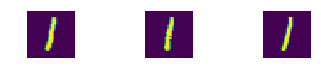

In [13]:
sample = np.random.choice(list(train_valid_similar_imgs.keys()))
print("train & test dataset Overlapping Images : ")
displayIdenticalImgs(np.append([X_train[sample]],train_valid_similar_imgs[sample],axis=0))

### Normalization

In [11]:
X_norm_train = tf.Session().run(tf.map_fn(lambda img: tf.image.per_image_standardization(img),X_train.reshape(-1,*img_shape,1).astype(np.float32)))
X_norm_valid = tf.Session().run(tf.map_fn(lambda img: tf.image.per_image_standardization(img),X_valid.reshape(-1,*img_shape,1).astype(np.float32)))

### Augmentation

In [12]:
augment_config = {
    'featurewise_center':False,
    'samplewise_center':False,
    'featurewise_std_normalization':False,
    'samplewise_std_normalization':False,
    'zca_whitening':False,
    'zca_epsilon':1e-06,
    'rotation_range':0.0,
    'width_shift_range':0.0,
    'height_shift_range':0.0,
    'brightness_range':None,
    'shear_range':0.0,
    'zoom_range':0.0,
    'channel_shift_range':0.0,
    'fill_mode':'nearest',
    'cval':0.0,
    'horizontal_flip':False,
    'vertical_flip':False,
    'rescale':None,
    'preprocessing_function':None,
    'data_format':None,
    'validation_split':0.0
}
img_augment = ImageDataGenerator(**augment_config)

### One Hot Encoding 

In [13]:
y_norm_train = tf.Session().run(tf.one_hot(y_train,10))
y_norm_valid = tf.Session().run(tf.one_hot(y_valid,10))

## Model Creation

In [14]:
def train_model(inputs, predictions,optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) :
    model = Model(inputs=inputs, outputs=predictions)
    model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)
    return model

### Simple Neural Network

In [15]:
def get_nn_model(input_shape,output_shape) :
    # This returns a tensor
    inputs = Input(shape=input_shape)
    # Flattening The Image
    x = Flatten()(inputs)
    # a layer instance is callable on a tensor, and returns a tensor
    x = Dense(64, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    predictions = Dense(output_shape, activation='softmax')(x)

    # This creates a model that includes
    # the Input layer and three Dense layers
    return inputs,predictions

In [16]:
nn_model = train_model(*get_nn_model((*img_shape,1),10))

In [20]:
nn_model.fit(X_norm_train,y_norm_train,validation_data=(X_norm_valid,y_norm_valid),batch_size=32,epochs=1000)

Train on 35700 samples, validate on 6300 samples
Epoch 1/1000
35700/35700 [==============================] - 5s 151us/step - loss: 0.2853 - acc: 0.9119 - val_loss: 0.1479 - val_acc: 0.9540
Epoch 2/1000
35700/35700 [==============================] - 4s 111us/step - loss: 0.1352 - acc: 0.9598 - val_loss: 0.1239 - val_acc: 0.9621
Epoch 3/1000
35700/35700 [==============================] - 4s 112us/step - loss: 0.1014 - acc: 0.9680 - val_loss: 0.1285 - val_acc: 0.9638
Epoch 4/1000
35700/35700 [==============================] - 4s 111us/step - loss: 0.0822 - acc: 0.9757 - val_loss: 0.1306 - val_acc: 0.9617
Epoch 5/1000
35700/35700 [==============================] - 4s 109us/step - loss: 0.0693 - acc: 0.9796 - val_loss: 0.1179 - val_acc: 0.9692
Epoch 6/1000
35700/35700 [==============================] - 4s 107us/step - loss: 0.0591 - acc: 0.9822 - val_loss: 0.1237 - val_acc: 0.9694
Epoch 7/1000
35700/35700 [==============================] - 4s 105us/step - loss: 0.0535 - acc: 0.9841 - val_lo

Epoch 59/1000
35700/35700 [==============================] - 4s 108us/step - loss: 0.0057 - acc: 0.9989 - val_loss: 0.2758 - val_acc: 0.9722
Epoch 60/1000
35700/35700 [==============================] - 4s 107us/step - loss: 0.0068 - acc: 0.9987 - val_loss: 0.2558 - val_acc: 0.9751
Epoch 61/1000
35700/35700 [==============================] - 4s 105us/step - loss: 0.0086 - acc: 0.9978 - val_loss: 0.2658 - val_acc: 0.9727
Epoch 62/1000
35700/35700 [==============================] - 4s 104us/step - loss: 0.0064 - acc: 0.9986 - val_loss: 0.2685 - val_acc: 0.9748
Epoch 63/1000
35700/35700 [==============================] - 4s 109us/step - loss: 0.0043 - acc: 0.9990 - val_loss: 0.2747 - val_acc: 0.9732
Epoch 64/1000
35700/35700 [==============================] - 4s 106us/step - loss: 0.0041 - acc: 0.9991 - val_loss: 0.2773 - val_acc: 0.9746
Epoch 65/1000
35700/35700 [==============================] - 4s 106us/step - loss: 0.0036 - acc: 0.9992 - val_loss: 0.2966 - val_acc: 0.9713
Epoch 66/1000

Epoch 117/1000
35700/35700 [==============================] - 4s 107us/step - loss: 0.0025 - acc: 0.9994 - val_loss: 0.3219 - val_acc: 0.9732
Epoch 118/1000
35700/35700 [==============================] - 4s 106us/step - loss: 0.0022 - acc: 0.9997 - val_loss: 0.3128 - val_acc: 0.9751
Epoch 119/1000
35700/35700 [==============================] - 4s 105us/step - loss: 0.0026 - acc: 0.9996 - val_loss: 0.3096 - val_acc: 0.9746
Epoch 120/1000
35700/35700 [==============================] - 4s 108us/step - loss: 0.0021 - acc: 0.9997 - val_loss: 0.2924 - val_acc: 0.9760
Epoch 121/1000
35700/35700 [==============================] - 4s 108us/step - loss: 0.0022 - acc: 0.9996 - val_loss: 0.2971 - val_acc: 0.9759
Epoch 122/1000
35700/35700 [==============================] - 4s 107us/step - loss: 0.0026 - acc: 0.9996 - val_loss: 0.3235 - val_acc: 0.9725
Epoch 123/1000
35700/35700 [==============================] - 4s 105us/step - loss: 0.0021 - acc: 0.9996 - val_loss: 0.3130 - val_acc: 0.9732
Epoch 

Epoch 231/1000
35700/35700 [==============================] - 4s 109us/step - loss: 9.0309e-04 - acc: 0.9999 - val_loss: 0.3060 - val_acc: 0.9763
Epoch 232/1000
35700/35700 [==============================] - 4s 116us/step - loss: 9.0309e-04 - acc: 0.9999 - val_loss: 0.3060 - val_acc: 0.9763
Epoch 233/1000
35700/35700 [==============================] - 4s 113us/step - loss: 9.0309e-04 - acc: 0.9999 - val_loss: 0.3060 - val_acc: 0.9763
Epoch 234/1000
35700/35700 [==============================] - 4s 108us/step - loss: 9.0309e-04 - acc: 0.9999 - val_loss: 0.3060 - val_acc: 0.9763
Epoch 235/1000
35700/35700 [==============================] - 4s 113us/step - loss: 9.0309e-04 - acc: 0.9999 - val_loss: 0.3060 - val_acc: 0.9763
Epoch 236/1000
35700/35700 [==============================] - 4s 111us/step - loss: 9.0309e-04 - acc: 0.9999 - val_loss: 0.3060 - val_acc: 0.9763
Epoch 237/1000
35700/35700 [==============================] - 4s 110us/step - loss: 9.0309e-04 - acc: 0.9999 - val_loss: 0.3

35700/35700 [==============================] - 4s 107us/step - loss: 9.0309e-04 - acc: 0.9999 - val_loss: 0.3060 - val_acc: 0.9763
Epoch 344/1000
35700/35700 [==============================] - 4s 113us/step - loss: 9.0309e-04 - acc: 0.9999 - val_loss: 0.3060 - val_acc: 0.9763
Epoch 345/1000
35700/35700 [==============================] - 4s 108us/step - loss: 9.0309e-04 - acc: 0.9999 - val_loss: 0.3060 - val_acc: 0.9763
Epoch 346/1000
35700/35700 [==============================] - 4s 112us/step - loss: 9.0309e-04 - acc: 0.9999 - val_loss: 0.3060 - val_acc: 0.9763
Epoch 347/1000
35700/35700 [==============================] - 4s 108us/step - loss: 9.0309e-04 - acc: 0.9999 - val_loss: 0.3060 - val_acc: 0.9763
Epoch 348/1000
35700/35700 [==============================] - 4s 113us/step - loss: 9.0309e-04 - acc: 0.9999 - val_loss: 0.3060 - val_acc: 0.9763
Epoch 349/1000
35700/35700 [==============================] - 4s 111us/step - loss: 9.0309e-04 - acc: 0.9999 - val_loss: 0.3060 - val_acc: 

35700/35700 [==============================] - 4s 108us/step - loss: 9.0309e-04 - acc: 0.9999 - val_loss: 0.3060 - val_acc: 0.9763
Epoch 456/1000
35700/35700 [==============================] - 4s 118us/step - loss: 9.0309e-04 - acc: 0.9999 - val_loss: 0.3060 - val_acc: 0.9763
Epoch 457/1000
35700/35700 [==============================] - 5s 144us/step - loss: 9.0309e-04 - acc: 0.9999 - val_loss: 0.3060 - val_acc: 0.9763
Epoch 458/1000
35700/35700 [==============================] - 6s 181us/step - loss: 9.0309e-04 - acc: 0.9999 - val_loss: 0.3060 - val_acc: 0.9763
Epoch 459/1000
35700/35700 [==============================] - 4s 111us/step - loss: 9.0309e-04 - acc: 0.9999 - val_loss: 0.3060 - val_acc: 0.9763
Epoch 460/1000
35700/35700 [==============================] - 4s 112us/step - loss: 9.0309e-04 - acc: 0.9999 - val_loss: 0.3060 - val_acc: 0.9763
Epoch 461/1000
35700/35700 [==============================] - 4s 115us/step - loss: 9.0309e-04 - acc: 0.9999 - val_loss: 0.3060 - val_acc: 

35700/35700 [==============================] - 4s 101us/step - loss: 9.0309e-04 - acc: 0.9999 - val_loss: 0.3060 - val_acc: 0.9763
Epoch 568/1000
35700/35700 [==============================] - 4s 106us/step - loss: 9.0309e-04 - acc: 0.9999 - val_loss: 0.3060 - val_acc: 0.9763
Epoch 569/1000
35700/35700 [==============================] - 4s 104us/step - loss: 9.0309e-04 - acc: 0.9999 - val_loss: 0.3060 - val_acc: 0.9763
Epoch 570/1000
35700/35700 [==============================] - 4s 105us/step - loss: 9.0309e-04 - acc: 0.9999 - val_loss: 0.3060 - val_acc: 0.9763
Epoch 571/1000
35700/35700 [==============================] - 4s 99us/step - loss: 9.0309e-04 - acc: 0.9999 - val_loss: 0.3060 - val_acc: 0.9763
Epoch 572/1000
35700/35700 [==============================] - 4s 106us/step - loss: 9.0309e-04 - acc: 0.9999 - val_loss: 0.3060 - val_acc: 0.9763
Epoch 573/1000
35700/35700 [==============================] - 4s 103us/step - loss: 9.0309e-04 - acc: 0.9999 - val_loss: 0.3060 - val_acc: 0

35700/35700 [==============================] - 4s 113us/step - loss: 9.0309e-04 - acc: 0.9999 - val_loss: 0.3060 - val_acc: 0.9763
Epoch 680/1000
35700/35700 [==============================] - 4s 111us/step - loss: 9.0309e-04 - acc: 0.9999 - val_loss: 0.3060 - val_acc: 0.9763
Epoch 681/1000
35700/35700 [==============================] - 4s 109us/step - loss: 9.0309e-04 - acc: 0.9999 - val_loss: 0.3060 - val_acc: 0.9763
Epoch 682/1000
35700/35700 [==============================] - 4s 109us/step - loss: 9.0309e-04 - acc: 0.9999 - val_loss: 0.3060 - val_acc: 0.9763
Epoch 683/1000
35700/35700 [==============================] - 4s 111us/step - loss: 9.0309e-04 - acc: 0.9999 - val_loss: 0.3060 - val_acc: 0.9763
Epoch 684/1000
35700/35700 [==============================] - 4s 110us/step - loss: 9.0309e-04 - acc: 0.9999 - val_loss: 0.3060 - val_acc: 0.9763
Epoch 685/1000
35700/35700 [==============================] - 4s 109us/step - loss: 9.0309e-04 - acc: 0.9999 - val_loss: 0.3060 - val_acc: 

35700/35700 [==============================] - 4s 103us/step - loss: 9.0309e-04 - acc: 0.9999 - val_loss: 0.3060 - val_acc: 0.9763
Epoch 792/1000
35700/35700 [==============================] - 4s 112us/step - loss: 9.0309e-04 - acc: 0.9999 - val_loss: 0.3060 - val_acc: 0.9763
Epoch 793/1000
35700/35700 [==============================] - 4s 112us/step - loss: 9.0309e-04 - acc: 0.9999 - val_loss: 0.3060 - val_acc: 0.9763
Epoch 794/1000
35700/35700 [==============================] - 4s 117us/step - loss: 9.0309e-04 - acc: 0.9999 - val_loss: 0.3060 - val_acc: 0.9763
Epoch 795/1000
35700/35700 [==============================] - 5s 133us/step - loss: 9.0309e-04 - acc: 0.9999 - val_loss: 0.3060 - val_acc: 0.9763
Epoch 796/1000
35700/35700 [==============================] - 5s 141us/step - loss: 9.0309e-04 - acc: 0.9999 - val_loss: 0.3060 - val_acc: 0.9763
Epoch 797/1000
35700/35700 [==============================] - 4s 122us/step - loss: 9.0309e-04 - acc: 0.9999 - val_loss: 0.3060 - val_acc: 

35700/35700 [==============================] - 4s 105us/step - loss: 9.0309e-04 - acc: 0.9999 - val_loss: 0.3060 - val_acc: 0.9763
Epoch 848/1000
35700/35700 [==============================] - 4s 111us/step - loss: 9.0309e-04 - acc: 0.9999 - val_loss: 0.3060 - val_acc: 0.9763
Epoch 849/1000
35700/35700 [==============================] - 4s 109us/step - loss: 9.0309e-04 - acc: 0.9999 - val_loss: 0.3060 - val_acc: 0.9763
Epoch 850/1000
35700/35700 [==============================] - 4s 113us/step - loss: 9.0309e-04 - acc: 0.9999 - val_loss: 0.3060 - val_acc: 0.9763
Epoch 851/1000
35700/35700 [==============================] - 4s 108us/step - loss: 9.0309e-04 - acc: 0.9999 - val_loss: 0.3060 - val_acc: 0.9763
Epoch 852/1000
35700/35700 [==============================] - 4s 111us/step - loss: 9.0309e-04 - acc: 0.9999 - val_loss: 0.3060 - val_acc: 0.9763
Epoch 853/1000
35700/35700 [==============================] - 4s 110us/step - loss: 9.0309e-04 - acc: 0.9999 - val_loss: 0.3060 - val_acc: 

35700/35700 [==============================] - 4s 109us/step - loss: 9.0309e-04 - acc: 0.9999 - val_loss: 0.3060 - val_acc: 0.9763
Epoch 960/1000
35700/35700 [==============================] - 4s 103us/step - loss: 9.0309e-04 - acc: 0.9999 - val_loss: 0.3060 - val_acc: 0.9763
Epoch 961/1000
35700/35700 [==============================] - 5s 151us/step - loss: 9.0309e-04 - acc: 0.9999 - val_loss: 0.3060 - val_acc: 0.9763
Epoch 962/1000
35700/35700 [==============================] - 4s 109us/step - loss: 9.0309e-04 - acc: 0.9999 - val_loss: 0.3060 - val_acc: 0.9763
Epoch 963/1000
35700/35700 [==============================] - 4s 115us/step - loss: 9.0309e-04 - acc: 0.9999 - val_loss: 0.3060 - val_acc: 0.9763
Epoch 964/1000
35700/35700 [==============================] - 4s 123us/step - loss: 9.0309e-04 - acc: 0.9999 - val_loss: 0.3060 - val_acc: 0.9763
Epoch 965/1000
35700/35700 [==============================] - 4s 119us/step - loss: 9.0309e-04 - acc: 0.9999 - val_loss: 0.3060 - val_acc: 

Saving the simple neural network model :

In [21]:
nn_model.save(os.path.join(models_root,'simple_nn_model.h5'))

'saved_models\\simple_nn_model.h5'

### Convolutional Neural Network

In [17]:
def get_cnn_model(input_shape,output_shape,activation='selu') :
    inputs = Input(shape=input_shape)
    y = Conv2D(16, 3, padding='same', activation=activation)(inputs)
    y = Conv2D(32, 3, padding='same', activation=activation)(y)
    y = Conv2D(64, 5, padding='same', activation=activation)(y)
    y = Flatten()(y)
    y = Dense(64, activation=activation)(y)
    y = Dense(64, activation=activation)(y)
    predictions = Dense(10, activation='softmax')(y)

    return inputs,predictions

## CNN

In [18]:
cnn_model = train_model(*get_cnn_model((*img_shape,1),10))

In [21]:
cnn_model.fit(X_norm_train,y_norm_train,validation_data=(X_norm_valid,y_norm_valid),batch_size=32,epochs=1000)

Train on 35700 samples, validate on 6300 samples
Epoch 1/1000
35700/35700 [==============================] - 23s 640us/step - loss: 0.0959 - acc: 0.9889 - val_loss: 0.3515 - val_acc: 0.9659
Epoch 2/1000
35700/35700 [==============================] - 23s 635us/step - loss: 0.0727 - acc: 0.9907 - val_loss: 0.3267 - val_acc: 0.9700
Epoch 3/1000
35700/35700 [==============================] - 23s 636us/step - loss: 0.1162 - acc: 0.9871 - val_loss: 0.3582 - val_acc: 0.9673
Epoch 4/1000
35700/35700 [==============================] - 23s 635us/step - loss: 0.1427 - acc: 0.9865 - val_loss: 0.4208 - val_acc: 0.9662
Epoch 5/1000
35700/35700 [==============================] - 23s 635us/step - loss: 0.1501 - acc: 0.9864 - val_loss: 0.3849 - val_acc: 0.9686
Epoch 6/1000
35700/35700 [==============================] - 23s 636us/step - loss: 0.1445 - acc: 0.9869 - val_loss: 0.5747 - val_acc: 0.9525
Epoch 7/1000
35700/35700 [==============================] - 23s 635us/step - loss: 0.1429 - acc: 0.9862 -

35700/35700 [==============================] - 23s 634us/step - loss: 0.6943 - acc: 0.9175 - val_loss: 0.9546 - val_acc: 0.9178
Epoch 59/1000
35700/35700 [==============================] - 23s 632us/step - loss: 1.0881 - acc: 0.9093 - val_loss: 1.3170 - val_acc: 0.9014
Epoch 60/1000
35700/35700 [==============================] - 23s 633us/step - loss: 1.5341 - acc: 0.8831 - val_loss: 1.0128 - val_acc: 0.9016
Epoch 61/1000
35700/35700 [==============================] - 23s 634us/step - loss: 1.1734 - acc: 0.8996 - val_loss: 0.9382 - val_acc: 0.9067
Epoch 62/1000
35700/35700 [==============================] - 23s 633us/step - loss: 0.9355 - acc: 0.9001 - val_loss: 0.8048 - val_acc: 0.9170
Epoch 63/1000
35700/35700 [==============================] - 23s 633us/step - loss: 0.6859 - acc: 0.9165 - val_loss: 0.8327 - val_acc: 0.8802
Epoch 64/1000
35700/35700 [==============================] - 23s 633us/step - loss: 0.9076 - acc: 0.8901 - val_loss: 0.9018 - val_acc: 0.8611
Epoch 65/1000
35700/

35700/35700 [==============================] - 23s 633us/step - loss: 1.0617 - acc: 0.8960 - val_loss: 1.0810 - val_acc: 0.8965
Epoch 116/1000
35700/35700 [==============================] - 23s 633us/step - loss: 1.9568 - acc: 0.8389 - val_loss: 1.3224 - val_acc: 0.8968
Epoch 117/1000
35700/35700 [==============================] - 23s 633us/step - loss: 1.1957 - acc: 0.8956 - val_loss: 1.3050 - val_acc: 0.8870
Epoch 118/1000
35700/35700 [==============================] - 23s 632us/step - loss: 0.9294 - acc: 0.9057 - val_loss: 0.7673 - val_acc: 0.9089
Epoch 119/1000
35700/35700 [==============================] - 23s 633us/step - loss: 0.7760 - acc: 0.9085 - val_loss: 0.8266 - val_acc: 0.9167
Epoch 120/1000
35700/35700 [==============================] - 23s 633us/step - loss: 0.7950 - acc: 0.9177 - val_loss: 0.8250 - val_acc: 0.9165
Epoch 121/1000
35700/35700 [==============================] - 23s 634us/step - loss: 1.2396 - acc: 0.8948 - val_loss: 1.5104 - val_acc: 0.8856
Epoch 122/1000

35700/35700 [==============================] - 23s 632us/step - loss: 1.1434 - acc: 0.9241 - val_loss: 1.2119 - val_acc: 0.9202
Epoch 173/1000
35700/35700 [==============================] - 23s 633us/step - loss: 1.1390 - acc: 0.9242 - val_loss: 1.3754 - val_acc: 0.9090
Epoch 174/1000
35700/35700 [==============================] - 23s 633us/step - loss: 1.2993 - acc: 0.9081 - val_loss: 1.2638 - val_acc: 0.8940
Epoch 175/1000
35700/35700 [==============================] - 24s 665us/step - loss: 1.5594 - acc: 0.8666 - val_loss: 1.8090 - val_acc: 0.8397
Epoch 176/1000
35700/35700 [==============================] - 23s 632us/step - loss: 1.7623 - acc: 0.8408 - val_loss: 1.8146 - val_acc: 0.8397
Epoch 177/1000
35700/35700 [==============================] - 23s 633us/step - loss: 1.0369 - acc: 0.9074 - val_loss: 1.0695 - val_acc: 0.9056
Epoch 178/1000
35700/35700 [==============================] - 23s 632us/step - loss: 1.0025 - acc: 0.9125 - val_loss: 1.0723 - val_acc: 0.9076
Epoch 179/1000

35700/35700 [==============================] - 23s 633us/step - loss: 1.7988 - acc: 0.8799 - val_loss: 1.7792 - val_acc: 0.8795
Epoch 230/1000
35700/35700 [==============================] - 23s 633us/step - loss: 1.8002 - acc: 0.8797 - val_loss: 1.7843 - val_acc: 0.8792
Epoch 231/1000
35700/35700 [==============================] - 23s 632us/step - loss: 1.7996 - acc: 0.8796 - val_loss: 1.7864 - val_acc: 0.8792
Epoch 232/1000
35700/35700 [==============================] - 23s 633us/step - loss: 1.7649 - acc: 0.8838 - val_loss: 1.7760 - val_acc: 0.8876
Epoch 233/1000
35700/35700 [==============================] - 23s 633us/step - loss: 1.3959 - acc: 0.9116 - val_loss: 1.1892 - val_acc: 0.9244
Epoch 234/1000
35700/35700 [==============================] - 23s 633us/step - loss: 1.2846 - acc: 0.9179 - val_loss: 1.3961 - val_acc: 0.9103
Epoch 235/1000
35700/35700 [==============================] - 23s 633us/step - loss: 1.3428 - acc: 0.9140 - val_loss: 1.3879 - val_acc: 0.9108
Epoch 236/1000

35700/35700 [==============================] - 23s 633us/step - loss: 1.3642 - acc: 0.9092 - val_loss: 1.3960 - val_acc: 0.9079
Epoch 287/1000
35700/35700 [==============================] - 23s 633us/step - loss: 1.3699 - acc: 0.9096 - val_loss: 1.3669 - val_acc: 0.9097
Epoch 288/1000
35700/35700 [==============================] - 23s 633us/step - loss: 1.3677 - acc: 0.9094 - val_loss: 1.3720 - val_acc: 0.9095
Epoch 289/1000
35700/35700 [==============================] - 23s 633us/step - loss: 1.3673 - acc: 0.9094 - val_loss: 1.3928 - val_acc: 0.9083
Epoch 290/1000
35700/35700 [==============================] - 23s 633us/step - loss: 1.4090 - acc: 0.9069 - val_loss: 1.9806 - val_acc: 0.8708
Epoch 291/1000
35700/35700 [==============================] - 23s 633us/step - loss: 1.8343 - acc: 0.8794 - val_loss: 1.3884 - val_acc: 0.9092
Epoch 292/1000
35700/35700 [==============================] - 23s 634us/step - loss: 1.7069 - acc: 0.8885 - val_loss: 3.7110 - val_acc: 0.7695
Epoch 293/1000

35700/35700 [==============================] - 23s 633us/step - loss: 1.7795 - acc: 0.8888 - val_loss: 1.7044 - val_acc: 0.8906
Epoch 344/1000
35700/35700 [==============================] - 23s 633us/step - loss: 1.7190 - acc: 0.8908 - val_loss: 1.6964 - val_acc: 0.8910
Epoch 345/1000
35700/35700 [==============================] - 23s 632us/step - loss: 1.7161 - acc: 0.8911 - val_loss: 1.7043 - val_acc: 0.8913
Epoch 346/1000
35700/35700 [==============================] - 23s 633us/step - loss: 1.7202 - acc: 0.8908 - val_loss: 1.7040 - val_acc: 0.8905
Epoch 347/1000
35700/35700 [==============================] - 23s 633us/step - loss: 1.7233 - acc: 0.8907 - val_loss: 1.7088 - val_acc: 0.8910
Epoch 348/1000
35700/35700 [==============================] - 23s 633us/step - loss: 1.7384 - acc: 0.8896 - val_loss: 1.9704 - val_acc: 0.8748
Epoch 349/1000
35700/35700 [==============================] - 23s 632us/step - loss: 1.9171 - acc: 0.8779 - val_loss: 1.9897 - val_acc: 0.8743
Epoch 350/1000

35700/35700 [==============================] - 23s 634us/step - loss: 1.5482 - acc: 0.8983 - val_loss: 2.4072 - val_acc: 0.8492
Epoch 401/1000
35700/35700 [==============================] - 23s 632us/step - loss: 1.9718 - acc: 0.8748 - val_loss: 1.7012 - val_acc: 0.8900
Epoch 402/1000
35700/35700 [==============================] - 23s 632us/step - loss: 1.6639 - acc: 0.8928 - val_loss: 1.7527 - val_acc: 0.8873
Epoch 403/1000
35700/35700 [==============================] - 23s 633us/step - loss: 1.2018 - acc: 0.9222 - val_loss: 1.2324 - val_acc: 0.9208
Epoch 404/1000
35700/35700 [==============================] - 23s 633us/step - loss: 1.1902 - acc: 0.9231 - val_loss: 1.2423 - val_acc: 0.9202
Epoch 405/1000
35700/35700 [==============================] - 23s 632us/step - loss: 1.1985 - acc: 0.9225 - val_loss: 1.2495 - val_acc: 0.9198
Epoch 406/1000
35700/35700 [==============================] - 23s 632us/step - loss: 1.1980 - acc: 0.9226 - val_loss: 1.2195 - val_acc: 0.9216
Epoch 407/1000

35700/35700 [==============================] - 23s 632us/step - loss: 2.6151 - acc: 0.8375 - val_loss: 2.5662 - val_acc: 0.8408
Epoch 458/1000
35700/35700 [==============================] - 23s 633us/step - loss: 2.6228 - acc: 0.8371 - val_loss: 2.5565 - val_acc: 0.8410
Epoch 459/1000
35700/35700 [==============================] - 23s 632us/step - loss: 2.3561 - acc: 0.8537 - val_loss: 2.1627 - val_acc: 0.8656
Epoch 460/1000
35700/35700 [==============================] - 23s 633us/step - loss: 2.2935 - acc: 0.8575 - val_loss: 2.1627 - val_acc: 0.8656
Epoch 461/1000
35700/35700 [==============================] - 23s 633us/step - loss: 2.1798 - acc: 0.8646 - val_loss: 1.8037 - val_acc: 0.8881
Epoch 462/1000
35700/35700 [==============================] - 23s 633us/step - loss: 1.8907 - acc: 0.8826 - val_loss: 2.2825 - val_acc: 0.8581
Epoch 463/1000
35700/35700 [==============================] - 23s 633us/step - loss: 2.4032 - acc: 0.8506 - val_loss: 2.3826 - val_acc: 0.8521
Epoch 464/1000

35700/35700 [==============================] - 23s 633us/step - loss: 6.2432 - acc: 0.6127 - val_loss: 6.2221 - val_acc: 0.6140
Epoch 515/1000
35700/35700 [==============================] - 23s 633us/step - loss: 6.2432 - acc: 0.6127 - val_loss: 6.2221 - val_acc: 0.6140
Epoch 516/1000
35700/35700 [==============================] - 23s 634us/step - loss: 6.2432 - acc: 0.6127 - val_loss: 6.2221 - val_acc: 0.6140
Epoch 517/1000
35700/35700 [==============================] - 23s 634us/step - loss: 6.2432 - acc: 0.6127 - val_loss: 6.2221 - val_acc: 0.6140
Epoch 518/1000
35700/35700 [==============================] - 23s 633us/step - loss: 6.2432 - acc: 0.6127 - val_loss: 6.2221 - val_acc: 0.6140
Epoch 519/1000
35700/35700 [==============================] - 23s 634us/step - loss: 6.2432 - acc: 0.6127 - val_loss: 6.2221 - val_acc: 0.6140
Epoch 520/1000
35700/35700 [==============================] - 23s 634us/step - loss: 6.2432 - acc: 0.6127 - val_loss: 6.2221 - val_acc: 0.6140
Epoch 521/1000

35700/35700 [==============================] - 23s 633us/step - loss: 6.2432 - acc: 0.6127 - val_loss: 6.2221 - val_acc: 0.6140
Epoch 572/1000
35700/35700 [==============================] - 23s 633us/step - loss: 6.2432 - acc: 0.6127 - val_loss: 6.2221 - val_acc: 0.6140
Epoch 573/1000
35700/35700 [==============================] - 23s 655us/step - loss: 6.2432 - acc: 0.6127 - val_loss: 6.2221 - val_acc: 0.6140
Epoch 574/1000
35700/35700 [==============================] - 23s 632us/step - loss: 6.2432 - acc: 0.6127 - val_loss: 6.2221 - val_acc: 0.6140
Epoch 575/1000
35700/35700 [==============================] - 23s 633us/step - loss: 6.2432 - acc: 0.6127 - val_loss: 6.2221 - val_acc: 0.6140
Epoch 576/1000
35700/35700 [==============================] - 23s 633us/step - loss: 6.2432 - acc: 0.6127 - val_loss: 6.2221 - val_acc: 0.6140
Epoch 577/1000
35700/35700 [==============================] - 23s 633us/step - loss: 6.2432 - acc: 0.6127 - val_loss: 6.2221 - val_acc: 0.6140
Epoch 578/1000

35700/35700 [==============================] - 23s 633us/step - loss: 6.2432 - acc: 0.6127 - val_loss: 6.2221 - val_acc: 0.6140
Epoch 629/1000
35700/35700 [==============================] - 23s 633us/step - loss: 6.2432 - acc: 0.6127 - val_loss: 6.2221 - val_acc: 0.6140
Epoch 630/1000
35700/35700 [==============================] - 23s 633us/step - loss: 6.2432 - acc: 0.6127 - val_loss: 6.2221 - val_acc: 0.6140
Epoch 631/1000
35700/35700 [==============================] - 23s 633us/step - loss: 6.2432 - acc: 0.6127 - val_loss: 6.2221 - val_acc: 0.6140
Epoch 632/1000
35700/35700 [==============================] - 23s 633us/step - loss: 6.2432 - acc: 0.6127 - val_loss: 6.2221 - val_acc: 0.6140
Epoch 633/1000
35700/35700 [==============================] - 23s 633us/step - loss: 6.2432 - acc: 0.6127 - val_loss: 6.2221 - val_acc: 0.6140
Epoch 634/1000
35700/35700 [==============================] - 23s 633us/step - loss: 6.2432 - acc: 0.6127 - val_loss: 6.2221 - val_acc: 0.6140
Epoch 635/1000

35700/35700 [==============================] - 23s 633us/step - loss: 6.2432 - acc: 0.6127 - val_loss: 6.2221 - val_acc: 0.6140
Epoch 686/1000
35700/35700 [==============================] - 23s 633us/step - loss: 6.2432 - acc: 0.6127 - val_loss: 6.2221 - val_acc: 0.6140
Epoch 687/1000
35700/35700 [==============================] - 23s 634us/step - loss: 6.2432 - acc: 0.6127 - val_loss: 6.2221 - val_acc: 0.6140
Epoch 688/1000
35700/35700 [==============================] - 23s 634us/step - loss: 6.2432 - acc: 0.6127 - val_loss: 6.2221 - val_acc: 0.6140
Epoch 689/1000
35700/35700 [==============================] - 23s 634us/step - loss: 6.2432 - acc: 0.6127 - val_loss: 6.2221 - val_acc: 0.6140
Epoch 690/1000
35700/35700 [==============================] - 23s 633us/step - loss: 6.2432 - acc: 0.6127 - val_loss: 6.2221 - val_acc: 0.6140
Epoch 691/1000
35700/35700 [==============================] - 23s 634us/step - loss: 6.2432 - acc: 0.6127 - val_loss: 6.2221 - val_acc: 0.6140
Epoch 692/1000

35700/35700 [==============================] - 23s 633us/step - loss: 6.2432 - acc: 0.6127 - val_loss: 6.2221 - val_acc: 0.6140
Epoch 743/1000
35700/35700 [==============================] - 23s 633us/step - loss: 6.2432 - acc: 0.6127 - val_loss: 6.2221 - val_acc: 0.6140
Epoch 744/1000
35700/35700 [==============================] - 23s 633us/step - loss: 6.2432 - acc: 0.6127 - val_loss: 6.2221 - val_acc: 0.6140
Epoch 745/1000
35700/35700 [==============================] - 23s 633us/step - loss: 6.2432 - acc: 0.6127 - val_loss: 6.2221 - val_acc: 0.6140
Epoch 746/1000
35700/35700 [==============================] - 23s 632us/step - loss: 6.2432 - acc: 0.6127 - val_loss: 6.2221 - val_acc: 0.6140
Epoch 747/1000
35700/35700 [==============================] - 23s 633us/step - loss: 6.2432 - acc: 0.6127 - val_loss: 6.2221 - val_acc: 0.6140
Epoch 748/1000
35700/35700 [==============================] - 23s 632us/step - loss: 6.2432 - acc: 0.6127 - val_loss: 6.2221 - val_acc: 0.6140
Epoch 749/1000

35700/35700 [==============================] - 23s 633us/step - loss: 6.2432 - acc: 0.6127 - val_loss: 6.2221 - val_acc: 0.6140
Epoch 800/1000
35700/35700 [==============================] - 23s 633us/step - loss: 6.2432 - acc: 0.6127 - val_loss: 6.2221 - val_acc: 0.6140
Epoch 801/1000
35700/35700 [==============================] - 23s 633us/step - loss: 6.2432 - acc: 0.6127 - val_loss: 6.2221 - val_acc: 0.6140
Epoch 802/1000
35700/35700 [==============================] - 23s 633us/step - loss: 6.2432 - acc: 0.6127 - val_loss: 6.2221 - val_acc: 0.6140
Epoch 803/1000
35700/35700 [==============================] - 23s 634us/step - loss: 6.2432 - acc: 0.6127 - val_loss: 6.2221 - val_acc: 0.6140
Epoch 804/1000
35700/35700 [==============================] - 23s 633us/step - loss: 6.2432 - acc: 0.6127 - val_loss: 6.2221 - val_acc: 0.6140
Epoch 805/1000
35700/35700 [==============================] - 23s 631us/step - loss: 6.2432 - acc: 0.6127 - val_loss: 6.2221 - val_acc: 0.6140
Epoch 806/1000

35700/35700 [==============================] - 23s 633us/step - loss: 6.2432 - acc: 0.6127 - val_loss: 6.2221 - val_acc: 0.6140
Epoch 857/1000
35700/35700 [==============================] - 23s 633us/step - loss: 6.2432 - acc: 0.6127 - val_loss: 6.2221 - val_acc: 0.6140
Epoch 858/1000
35700/35700 [==============================] - 23s 633us/step - loss: 6.2432 - acc: 0.6127 - val_loss: 6.2221 - val_acc: 0.6140
Epoch 859/1000
35700/35700 [==============================] - 23s 633us/step - loss: 6.2432 - acc: 0.6127 - val_loss: 6.2221 - val_acc: 0.6140
Epoch 860/1000
35700/35700 [==============================] - 23s 633us/step - loss: 6.2432 - acc: 0.6127 - val_loss: 6.2221 - val_acc: 0.6140
Epoch 861/1000
35700/35700 [==============================] - 23s 633us/step - loss: 6.2432 - acc: 0.6127 - val_loss: 6.2221 - val_acc: 0.6140
Epoch 862/1000
35700/35700 [==============================] - 23s 633us/step - loss: 6.2432 - acc: 0.6127 - val_loss: 6.2221 - val_acc: 0.6140
Epoch 863/1000

35700/35700 [==============================] - 23s 633us/step - loss: 6.2432 - acc: 0.6127 - val_loss: 6.2221 - val_acc: 0.6140
Epoch 914/1000
35700/35700 [==============================] - 23s 634us/step - loss: 6.2432 - acc: 0.6127 - val_loss: 6.2221 - val_acc: 0.6140
Epoch 915/1000
35700/35700 [==============================] - 23s 633us/step - loss: 6.2432 - acc: 0.6127 - val_loss: 6.2221 - val_acc: 0.6140
Epoch 916/1000
35700/35700 [==============================] - 23s 633us/step - loss: 6.2432 - acc: 0.6127 - val_loss: 6.2221 - val_acc: 0.6140
Epoch 917/1000
35700/35700 [==============================] - 23s 633us/step - loss: 6.2432 - acc: 0.6127 - val_loss: 6.2221 - val_acc: 0.6140
Epoch 918/1000
35700/35700 [==============================] - 23s 634us/step - loss: 6.2432 - acc: 0.6127 - val_loss: 6.2221 - val_acc: 0.6140
Epoch 919/1000
35700/35700 [==============================] - 23s 634us/step - loss: 6.2432 - acc: 0.6127 - val_loss: 6.2221 - val_acc: 0.6140
Epoch 920/1000

35700/35700 [==============================] - 23s 634us/step - loss: 6.2432 - acc: 0.6127 - val_loss: 6.2221 - val_acc: 0.6140
Epoch 971/1000
35700/35700 [==============================] - 23s 634us/step - loss: 6.2432 - acc: 0.6127 - val_loss: 6.2221 - val_acc: 0.6140
Epoch 972/1000
35700/35700 [==============================] - 23s 633us/step - loss: 6.2432 - acc: 0.6127 - val_loss: 6.2221 - val_acc: 0.6140
Epoch 973/1000
35700/35700 [==============================] - 23s 633us/step - loss: 6.2432 - acc: 0.6127 - val_loss: 6.2221 - val_acc: 0.6140
Epoch 974/1000
35700/35700 [==============================] - 23s 634us/step - loss: 6.2432 - acc: 0.6127 - val_loss: 6.2221 - val_acc: 0.6140
Epoch 975/1000
35700/35700 [==============================] - 23s 633us/step - loss: 6.2432 - acc: 0.6127 - val_loss: 6.2221 - val_acc: 0.6140
Epoch 976/1000
35700/35700 [==============================] - 23s 633us/step - loss: 6.2432 - acc: 0.6127 - val_loss: 6.2221 - val_acc: 0.6140
Epoch 977/1000

In [22]:
cnn_model.save(os.path.join(models_root,'simple_cnn_model.h5'))

## CNN with Relu activation

In [28]:
cnn_model = train_model(*get_cnn_model((*img_shape,1),10,'relu'))

In [29]:
cnn_model.fit(X_norm_train,y_norm_train,validation_data=(X_norm_valid,y_norm_valid),batch_size=32,epochs=1000)

Train on 35700 samples, validate on 6300 samples
Epoch 1/3
35700/35700 [==============================] - 17s 489us/step - loss: 0.1733 - acc: 0.9479 - val_loss: 0.0470 - val_acc: 0.9867
Epoch 2/3
35700/35700 [==============================] - 15s 424us/step - loss: 0.0601 - acc: 0.9831 - val_loss: 0.0449 - val_acc: 0.9862
Epoch 3/3
35700/35700 [==============================] - 15s 429us/step - loss: 0.0455 - acc: 0.9876 - val_loss: 0.0624 - val_acc: 0.9797


## CNN with LeakyRelu activation

In [33]:
cnn_model = train_model(*get_cnn_model((*img_shape,1),10,LeakyReLU()))

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\envs\deeplearning\lib\site-packages\keras\activations.py:186: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


In [34]:
cnn_model.fit(X_norm_train,y_norm_train,validation_data=(X_norm_valid,y_norm_valid),epochs=3)

Train on 35700 samples, validate on 6300 samples
Epoch 1/3
35700/35700 [==============================] - 19s 536us/step - loss: 0.1687 - acc: 0.9483 - val_loss: 0.0698 - val_acc: 0.9783
Epoch 2/3
35700/35700 [==============================] - 20s 571us/step - loss: 0.0802 - acc: 0.9764 - val_loss: 0.1144 - val_acc: 0.9671
Epoch 3/3
35700/35700 [==============================] - 18s 498us/step - loss: 0.0665 - acc: 0.9811 - val_loss: 0.0674 - val_acc: 0.9806


## CNN with Parametric Relu activation

In [ ]:
cnn_model = train_model(*get_cnn_model((*img_shape,1),10,PReLU()))

In [ ]:
cnn_model.fit(X_norm_train,y_norm_train,validation_data=(X_norm_valid,y_norm_valid),epochs=3)

### LeNet

In [23]:
def get_lenet_model(input_shape,output_shape) :
    inputs = Input(shape=input_shape)
    y = Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape)(inputs)
    y = Conv2D(64, (3, 3), activation='relu')(y)
    y = MaxPooling2D(pool_size=(2, 2))(y)
    y = Dropout(0.25)(y)
    y = Flatten()(y)
    y = Dense(128, activation='relu')(y)
    y = Dropout(0.5)(y)
    predictions = Dense(output_shape, activation='softmax')(y)
    return inputs,predictions

In [24]:
lenet_model = train_model(*get_lenet_model((*img_shape,1),10))

In [25]:
lenet_model.fit(X_norm_train,y_norm_train,validation_data=(X_norm_valid,y_norm_valid),batch_size=32,epochs=1000)

Train on 35700 samples, validate on 6300 samples
Epoch 1/1000
35700/35700 [==============================] - 12s 338us/step - loss: 0.2391 - acc: 0.9263 - val_loss: 0.0640 - val_acc: 0.9800
Epoch 2/1000
35700/35700 [==============================] - 11s 303us/step - loss: 0.1011 - acc: 0.9695 - val_loss: 0.0423 - val_acc: 0.9860
Epoch 3/1000
35700/35700 [==============================] - 11s 303us/step - loss: 0.0717 - acc: 0.9782 - val_loss: 0.0455 - val_acc: 0.9870
Epoch 4/1000
35700/35700 [==============================] - 11s 304us/step - loss: 0.0569 - acc: 0.9824 - val_loss: 0.0476 - val_acc: 0.9857
Epoch 5/1000
35700/35700 [==============================] - 11s 305us/step - loss: 0.0517 - acc: 0.9839 - val_loss: 0.0359 - val_acc: 0.9883
Epoch 6/1000
35700/35700 [==============================] - 11s 305us/step - loss: 0.0451 - acc: 0.9860 - val_loss: 0.0380 - val_acc: 0.9898
Epoch 7/1000
35700/35700 [==============================] - 11s 302us/step - loss: 0.0395 - acc: 0.9874 -

35700/35700 [==============================] - 11s 304us/step - loss: 0.0125 - acc: 0.9966 - val_loss: 0.0528 - val_acc: 0.9908
Epoch 59/1000
35700/35700 [==============================] - 11s 305us/step - loss: 0.0109 - acc: 0.9973 - val_loss: 0.0543 - val_acc: 0.9919
Epoch 60/1000
35700/35700 [==============================] - 11s 306us/step - loss: 0.0097 - acc: 0.9973 - val_loss: 0.0691 - val_acc: 0.9910
Epoch 61/1000
35700/35700 [==============================] - 12s 336us/step - loss: 0.0101 - acc: 0.9974 - val_loss: 0.0641 - val_acc: 0.9916
Epoch 62/1000
35700/35700 [==============================] - 11s 305us/step - loss: 0.0092 - acc: 0.9972 - val_loss: 0.0682 - val_acc: 0.9913
Epoch 63/1000
35700/35700 [==============================] - 11s 303us/step - loss: 0.0119 - acc: 0.9971 - val_loss: 0.0464 - val_acc: 0.9922
Epoch 64/1000
35700/35700 [==============================] - 12s 326us/step - loss: 0.0083 - acc: 0.9975 - val_loss: 0.0687 - val_acc: 0.9903
Epoch 65/1000
35700/

35700/35700 [==============================] - 11s 305us/step - loss: 0.0110 - acc: 0.9977 - val_loss: 0.0733 - val_acc: 0.9894
Epoch 116/1000
35700/35700 [==============================] - 11s 304us/step - loss: 0.0122 - acc: 0.9972 - val_loss: 0.0649 - val_acc: 0.9917
Epoch 117/1000
35700/35700 [==============================] - 11s 304us/step - loss: 0.0101 - acc: 0.9979 - val_loss: 0.0770 - val_acc: 0.9913
Epoch 118/1000
35700/35700 [==============================] - 11s 304us/step - loss: 0.0072 - acc: 0.9984 - val_loss: 0.0741 - val_acc: 0.9908
Epoch 119/1000
35700/35700 [==============================] - 11s 304us/step - loss: 0.0114 - acc: 0.9976 - val_loss: 0.0776 - val_acc: 0.9910
Epoch 120/1000
35700/35700 [==============================] - 11s 303us/step - loss: 0.0118 - acc: 0.9975 - val_loss: 0.0665 - val_acc: 0.9900
Epoch 121/1000
35700/35700 [==============================] - 11s 304us/step - loss: 0.0123 - acc: 0.9974 - val_loss: 0.0641 - val_acc: 0.9910
Epoch 122/1000

35700/35700 [==============================] - 11s 304us/step - loss: 0.0136 - acc: 0.9978 - val_loss: 0.0868 - val_acc: 0.9922
Epoch 173/1000
35700/35700 [==============================] - 11s 301us/step - loss: 0.0107 - acc: 0.9979 - val_loss: 0.1032 - val_acc: 0.9902
Epoch 174/1000
35700/35700 [==============================] - 11s 303us/step - loss: 0.0104 - acc: 0.9980 - val_loss: 0.0852 - val_acc: 0.9916
Epoch 175/1000
35700/35700 [==============================] - 11s 305us/step - loss: 0.0149 - acc: 0.9976 - val_loss: 0.0790 - val_acc: 0.9922
Epoch 176/1000
35700/35700 [==============================] - 11s 304us/step - loss: 0.0112 - acc: 0.9979 - val_loss: 0.0750 - val_acc: 0.9917
Epoch 177/1000
35700/35700 [==============================] - 11s 303us/step - loss: 0.0077 - acc: 0.9985 - val_loss: 0.0869 - val_acc: 0.9913
Epoch 178/1000
35700/35700 [==============================] - 11s 304us/step - loss: 0.0101 - acc: 0.9981 - val_loss: 0.0885 - val_acc: 0.9911
Epoch 179/1000

35700/35700 [==============================] - 11s 305us/step - loss: 0.0166 - acc: 0.9979 - val_loss: 0.0975 - val_acc: 0.9922
Epoch 230/1000
35700/35700 [==============================] - 11s 304us/step - loss: 0.0226 - acc: 0.9977 - val_loss: 0.0839 - val_acc: 0.9929
Epoch 231/1000
35700/35700 [==============================] - 11s 304us/step - loss: 0.0114 - acc: 0.9984 - val_loss: 0.0822 - val_acc: 0.9927
Epoch 232/1000
35700/35700 [==============================] - 11s 304us/step - loss: 0.0137 - acc: 0.9982 - val_loss: 0.1222 - val_acc: 0.9903
Epoch 233/1000
35700/35700 [==============================] - 11s 303us/step - loss: 0.0130 - acc: 0.9984 - val_loss: 0.0970 - val_acc: 0.9924
Epoch 234/1000
35700/35700 [==============================] - 11s 303us/step - loss: 0.0114 - acc: 0.9985 - val_loss: 0.0911 - val_acc: 0.9929
Epoch 235/1000
35700/35700 [==============================] - 11s 303us/step - loss: 0.0218 - acc: 0.9976 - val_loss: 0.1018 - val_acc: 0.9922
Epoch 236/1000

35700/35700 [==============================] - 11s 304us/step - loss: 0.0167 - acc: 0.9984 - val_loss: 0.1132 - val_acc: 0.9919
Epoch 287/1000
35700/35700 [==============================] - 11s 304us/step - loss: 0.0230 - acc: 0.9980 - val_loss: 0.1151 - val_acc: 0.9906
Epoch 288/1000
35700/35700 [==============================] - 11s 303us/step - loss: 0.0175 - acc: 0.9983 - val_loss: 0.1092 - val_acc: 0.9922
Epoch 289/1000
35700/35700 [==============================] - 11s 304us/step - loss: 0.0188 - acc: 0.9983 - val_loss: 0.1402 - val_acc: 0.9895
Epoch 290/1000
35700/35700 [==============================] - 11s 304us/step - loss: 0.0206 - acc: 0.9983 - val_loss: 0.1349 - val_acc: 0.9902
Epoch 291/1000
35700/35700 [==============================] - 11s 303us/step - loss: 0.0242 - acc: 0.9979 - val_loss: 0.1172 - val_acc: 0.9906
Epoch 292/1000
35700/35700 [==============================] - 11s 302us/step - loss: 0.0254 - acc: 0.9978 - val_loss: 0.1208 - val_acc: 0.9917
Epoch 293/1000

35700/35700 [==============================] - 11s 304us/step - loss: 0.0296 - acc: 0.9977 - val_loss: 0.1333 - val_acc: 0.9914
Epoch 344/1000
35700/35700 [==============================] - 11s 303us/step - loss: 0.0327 - acc: 0.9976 - val_loss: 0.1427 - val_acc: 0.9908
Epoch 345/1000
35700/35700 [==============================] - 11s 304us/step - loss: 0.0326 - acc: 0.9974 - val_loss: 0.1407 - val_acc: 0.9913
Epoch 346/1000
35700/35700 [==============================] - 11s 303us/step - loss: 0.0354 - acc: 0.9974 - val_loss: 0.1288 - val_acc: 0.9916
Epoch 347/1000
35700/35700 [==============================] - 11s 304us/step - loss: 0.0271 - acc: 0.9979 - val_loss: 0.1368 - val_acc: 0.9910
Epoch 348/1000
35700/35700 [==============================] - 11s 303us/step - loss: 0.0302 - acc: 0.9977 - val_loss: 0.1331 - val_acc: 0.9911
Epoch 349/1000
35700/35700 [==============================] - 11s 304us/step - loss: 0.0296 - acc: 0.9978 - val_loss: 0.1181 - val_acc: 0.9919
Epoch 350/1000

35700/35700 [==============================] - 11s 304us/step - loss: 0.0346 - acc: 0.9976 - val_loss: 0.1286 - val_acc: 0.9914
Epoch 401/1000
35700/35700 [==============================] - 11s 304us/step - loss: 0.0398 - acc: 0.9973 - val_loss: 0.1354 - val_acc: 0.9914
Epoch 402/1000
35700/35700 [==============================] - 11s 304us/step - loss: 0.0394 - acc: 0.9974 - val_loss: 0.1454 - val_acc: 0.9906
Epoch 403/1000
35700/35700 [==============================] - 11s 304us/step - loss: 0.0580 - acc: 0.9961 - val_loss: 0.1379 - val_acc: 0.9911
Epoch 404/1000
35700/35700 [==============================] - 11s 303us/step - loss: 0.0472 - acc: 0.9968 - val_loss: 0.1615 - val_acc: 0.9897
Epoch 405/1000
35700/35700 [==============================] - 11s 302us/step - loss: 0.0425 - acc: 0.9972 - val_loss: 0.1255 - val_acc: 0.9921
Epoch 406/1000
35700/35700 [==============================] - 11s 305us/step - loss: 0.0489 - acc: 0.9967 - val_loss: 0.1330 - val_acc: 0.9911
Epoch 407/1000

35700/35700 [==============================] - 11s 304us/step - loss: 0.0603 - acc: 0.9960 - val_loss: 0.1314 - val_acc: 0.9916
Epoch 458/1000
35700/35700 [==============================] - 11s 303us/step - loss: 0.0487 - acc: 0.9968 - val_loss: 0.1465 - val_acc: 0.9905
Epoch 459/1000
35700/35700 [==============================] - 11s 304us/step - loss: 0.0504 - acc: 0.9967 - val_loss: 0.1459 - val_acc: 0.9910
Epoch 460/1000
35700/35700 [==============================] - 11s 304us/step - loss: 0.0677 - acc: 0.9955 - val_loss: 0.1448 - val_acc: 0.9908
Epoch 461/1000
35700/35700 [==============================] - 11s 304us/step - loss: 0.0679 - acc: 0.9956 - val_loss: 0.1231 - val_acc: 0.9921
Epoch 462/1000
35700/35700 [==============================] - 11s 304us/step - loss: 0.0619 - acc: 0.9959 - val_loss: 0.1512 - val_acc: 0.9903
Epoch 463/1000
35700/35700 [==============================] - 11s 304us/step - loss: 0.0602 - acc: 0.9960 - val_loss: 0.1391 - val_acc: 0.9913
Epoch 464/1000

35700/35700 [==============================] - 11s 303us/step - loss: 0.0607 - acc: 0.9960 - val_loss: 0.1685 - val_acc: 0.9892
Epoch 515/1000
35700/35700 [==============================] - 11s 303us/step - loss: 0.0497 - acc: 0.9968 - val_loss: 0.1629 - val_acc: 0.9897
Epoch 516/1000
35700/35700 [==============================] - 11s 303us/step - loss: 0.0568 - acc: 0.9964 - val_loss: 0.1735 - val_acc: 0.9890
Epoch 517/1000
35700/35700 [==============================] - 11s 303us/step - loss: 0.0494 - acc: 0.9969 - val_loss: 0.1674 - val_acc: 0.9894
Epoch 518/1000
35700/35700 [==============================] - 11s 303us/step - loss: 0.0653 - acc: 0.9959 - val_loss: 0.1538 - val_acc: 0.9903
Epoch 519/1000
35700/35700 [==============================] - 11s 304us/step - loss: 0.0590 - acc: 0.9962 - val_loss: 0.1561 - val_acc: 0.9900
Epoch 520/1000
35700/35700 [==============================] - 11s 303us/step - loss: 0.0482 - acc: 0.9968 - val_loss: 0.1672 - val_acc: 0.9894
Epoch 521/1000

35700/35700 [==============================] - 11s 303us/step - loss: 0.0728 - acc: 0.9954 - val_loss: 0.1383 - val_acc: 0.9913
Epoch 572/1000
35700/35700 [==============================] - 12s 334us/step - loss: 0.0657 - acc: 0.9959 - val_loss: 0.1309 - val_acc: 0.9917
Epoch 573/1000
35700/35700 [==============================] - 11s 303us/step - loss: 0.0653 - acc: 0.9959 - val_loss: 0.1388 - val_acc: 0.9913
Epoch 574/1000
35700/35700 [==============================] - 11s 303us/step - loss: 0.0731 - acc: 0.9954 - val_loss: 0.1663 - val_acc: 0.9897
Epoch 575/1000
35700/35700 [==============================] - 11s 303us/step - loss: 0.0698 - acc: 0.9955 - val_loss: 0.1746 - val_acc: 0.9890
Epoch 576/1000
35700/35700 [==============================] - 11s 303us/step - loss: 0.0569 - acc: 0.9964 - val_loss: 0.1552 - val_acc: 0.9900
Epoch 577/1000
35700/35700 [==============================] - 11s 304us/step - loss: 0.0563 - acc: 0.9964 - val_loss: 0.1638 - val_acc: 0.9898
Epoch 578/1000

35700/35700 [==============================] - 11s 302us/step - loss: 0.0779 - acc: 0.9951 - val_loss: 0.1542 - val_acc: 0.9903
Epoch 629/1000
35700/35700 [==============================] - 11s 304us/step - loss: 0.0759 - acc: 0.9951 - val_loss: 0.1407 - val_acc: 0.9913
Epoch 630/1000
35700/35700 [==============================] - 11s 302us/step - loss: 0.0823 - acc: 0.9948 - val_loss: 0.1554 - val_acc: 0.9902
Epoch 631/1000
35700/35700 [==============================] - 11s 304us/step - loss: 0.0691 - acc: 0.9956 - val_loss: 0.1431 - val_acc: 0.9908
Epoch 632/1000
35700/35700 [==============================] - 11s 303us/step - loss: 0.0767 - acc: 0.9951 - val_loss: 0.1652 - val_acc: 0.9895
Epoch 633/1000
35700/35700 [==============================] - 11s 304us/step - loss: 0.0850 - acc: 0.9946 - val_loss: 0.1581 - val_acc: 0.9902
Epoch 634/1000
35700/35700 [==============================] - 11s 303us/step - loss: 0.0833 - acc: 0.9948 - val_loss: 0.1557 - val_acc: 0.9900
Epoch 635/1000

35700/35700 [==============================] - 11s 304us/step - loss: 0.0779 - acc: 0.9950 - val_loss: 0.1534 - val_acc: 0.9905
Epoch 686/1000
35700/35700 [==============================] - 11s 304us/step - loss: 0.0697 - acc: 0.9957 - val_loss: 0.1535 - val_acc: 0.9903
Epoch 687/1000
35700/35700 [==============================] - 11s 304us/step - loss: 0.0774 - acc: 0.9951 - val_loss: 0.1422 - val_acc: 0.9911
Epoch 688/1000
35700/35700 [==============================] - 11s 304us/step - loss: 0.0984 - acc: 0.9938 - val_loss: 0.1356 - val_acc: 0.9916
Epoch 689/1000
35700/35700 [==============================] - 11s 304us/step - loss: 0.0644 - acc: 0.9959 - val_loss: 0.1168 - val_acc: 0.9924
Epoch 690/1000
35700/35700 [==============================] - 11s 303us/step - loss: 0.0644 - acc: 0.9959 - val_loss: 0.1204 - val_acc: 0.9924
Epoch 691/1000
35700/35700 [==============================] - 11s 304us/step - loss: 0.0915 - acc: 0.9943 - val_loss: 0.1382 - val_acc: 0.9914
Epoch 692/1000

35700/35700 [==============================] - 11s 303us/step - loss: 0.1061 - acc: 0.9934 - val_loss: 0.1535 - val_acc: 0.9905
Epoch 743/1000
35700/35700 [==============================] - 11s 305us/step - loss: 0.0765 - acc: 0.9952 - val_loss: 0.1407 - val_acc: 0.9913
Epoch 744/1000
35700/35700 [==============================] - 11s 304us/step - loss: 0.0870 - acc: 0.9946 - val_loss: 0.1433 - val_acc: 0.9911
Epoch 745/1000
35700/35700 [==============================] - 11s 303us/step - loss: 0.0794 - acc: 0.9949 - val_loss: 0.1450 - val_acc: 0.9910
Epoch 746/1000
35700/35700 [==============================] - 11s 302us/step - loss: 0.0976 - acc: 0.9938 - val_loss: 0.1814 - val_acc: 0.9887
Epoch 747/1000
35700/35700 [==============================] - 11s 304us/step - loss: 0.1082 - acc: 0.9932 - val_loss: 0.2047 - val_acc: 0.9873
Epoch 748/1000
35700/35700 [==============================] - 11s 304us/step - loss: 0.1051 - acc: 0.9934 - val_loss: 0.1488 - val_acc: 0.9906
Epoch 749/1000

35700/35700 [==============================] - 11s 308us/step - loss: 0.0864 - acc: 0.9946 - val_loss: 0.1612 - val_acc: 0.9900
Epoch 800/1000
35700/35700 [==============================] - 11s 309us/step - loss: 0.0825 - acc: 0.9948 - val_loss: 0.1438 - val_acc: 0.9910
Epoch 801/1000
35700/35700 [==============================] - 11s 307us/step - loss: 0.0726 - acc: 0.9954 - val_loss: 0.1392 - val_acc: 0.9911
Epoch 802/1000
35700/35700 [==============================] - 11s 308us/step - loss: 0.0775 - acc: 0.9952 - val_loss: 0.1432 - val_acc: 0.9911
Epoch 803/1000
35700/35700 [==============================] - 11s 309us/step - loss: 0.0735 - acc: 0.9954 - val_loss: 0.1281 - val_acc: 0.9919
Epoch 804/1000
35700/35700 [==============================] - 11s 308us/step - loss: 0.0630 - acc: 0.9960 - val_loss: 0.1366 - val_acc: 0.9914
Epoch 805/1000
35700/35700 [==============================] - 11s 308us/step - loss: 0.0977 - acc: 0.9939 - val_loss: 0.1508 - val_acc: 0.9906
Epoch 806/1000

35700/35700 [==============================] - 11s 311us/step - loss: 0.0823 - acc: 0.9948 - val_loss: 0.1356 - val_acc: 0.9916
Epoch 857/1000
35700/35700 [==============================] - 11s 311us/step - loss: 0.0841 - acc: 0.9948 - val_loss: 0.1459 - val_acc: 0.9910
Epoch 858/1000
35700/35700 [==============================] - 11s 311us/step - loss: 0.1042 - acc: 0.9935 - val_loss: 0.1791 - val_acc: 0.9889
Epoch 859/1000
35700/35700 [==============================] - 11s 311us/step - loss: 0.1116 - acc: 0.9930 - val_loss: 0.1780 - val_acc: 0.9887
Epoch 860/1000
35700/35700 [==============================] - 11s 311us/step - loss: 0.1235 - acc: 0.9923 - val_loss: 0.1842 - val_acc: 0.9886
Epoch 861/1000
35700/35700 [==============================] - 11s 311us/step - loss: 0.1066 - acc: 0.9934 - val_loss: 0.1740 - val_acc: 0.9892
Epoch 862/1000
35700/35700 [==============================] - 11s 312us/step - loss: 0.1379 - acc: 0.9913 - val_loss: 0.1816 - val_acc: 0.9887
Epoch 863/1000

35700/35700 [==============================] - 23s 634us/step - loss: 0.0786 - acc: 0.9951 - val_loss: 0.1561 - val_acc: 0.9903
Epoch 914/1000
35700/35700 [==============================] - 22s 624us/step - loss: 0.0936 - acc: 0.9941 - val_loss: 0.1780 - val_acc: 0.9889
Epoch 915/1000
35700/35700 [==============================] - 24s 667us/step - loss: 0.1048 - acc: 0.9934 - val_loss: 0.1596 - val_acc: 0.9900
Epoch 916/1000
35700/35700 [==============================] - 24s 671us/step - loss: 0.0730 - acc: 0.9954 - val_loss: 0.1612 - val_acc: 0.9900
Epoch 917/1000
35700/35700 [==============================] - 19s 525us/step - loss: 0.0829 - acc: 0.9948 - val_loss: 0.1430 - val_acc: 0.9911
Epoch 918/1000
35700/35700 [==============================] - 14s 379us/step - loss: 0.0731 - acc: 0.9954 - val_loss: 0.1535 - val_acc: 0.9905
Epoch 919/1000
35700/35700 [==============================] - 12s 348us/step - loss: 0.0665 - acc: 0.9958 - val_loss: 0.1510 - val_acc: 0.9906
Epoch 920/1000

35700/35700 [==============================] - 11s 308us/step - loss: 0.0910 - acc: 0.9943 - val_loss: 0.1535 - val_acc: 0.9905
Epoch 971/1000
35700/35700 [==============================] - 11s 310us/step - loss: 0.0824 - acc: 0.9949 - val_loss: 0.1663 - val_acc: 0.9897
Epoch 972/1000
35700/35700 [==============================] - 11s 311us/step - loss: 0.0940 - acc: 0.9941 - val_loss: 0.1743 - val_acc: 0.9890
Epoch 973/1000
35700/35700 [==============================] - 11s 309us/step - loss: 0.1014 - acc: 0.9936 - val_loss: 0.1663 - val_acc: 0.9897
Epoch 974/1000
35700/35700 [==============================] - 11s 307us/step - loss: 0.0941 - acc: 0.9941 - val_loss: 0.1612 - val_acc: 0.9900
Epoch 975/1000
35700/35700 [==============================] - 11s 305us/step - loss: 0.0736 - acc: 0.9954 - val_loss: 0.1567 - val_acc: 0.9902
Epoch 976/1000
35700/35700 [==============================] - 11s 307us/step - loss: 0.0885 - acc: 0.9945 - val_loss: 0.1553 - val_acc: 0.9903
Epoch 977/1000

In [29]:
lenet_model.save(os.path.join(models_root,'lenet_model.h5'))

### Inception V4

In [26]:
def get_inception_v4_model(input_shape,output_shape) :
    '''
    Creates a inception v4 network
    :param nb_classes: number of classes.txt
    :return: Keras Model with 1 input and 1 output
    '''


    init = Input(shape=input_shape)


    x = inception_A(init)

    x = AveragePooling2D()(x)

    # Dropout
    x = Dropout(0.8)(x)
    x = Flatten()(x)

    # Output
    out = Dense(units=output_shape, activation='softmax')(x)


    return init, out

In [27]:
inception_v4_model = train_model(*get_inception_v4_model((*img_shape,1),10))

In [28]:
inception_v4_model.fit(X_norm_train,y_norm_train,validation_data=(X_norm_valid,y_norm_valid),batch_size=32,epochs=1000)

Train on 35700 samples, validate on 6300 samples
Epoch 1/1000
35700/35700 [==============================] - 53s 1ms/step - loss: 2.2996 - acc: 0.8180 - val_loss: 1.9163 - val_acc: 0.8659
Epoch 2/1000
35700/35700 [==============================] - 50s 1ms/step - loss: 1.3111 - acc: 0.8954 - val_loss: 0.2769 - val_acc: 0.9676
Epoch 3/1000
35700/35700 [==============================] - 51s 1ms/step - loss: 0.4322 - acc: 0.9515 - val_loss: 0.2034 - val_acc: 0.9751
Epoch 4/1000
35700/35700 [==============================] - 51s 1ms/step - loss: 0.3106 - acc: 0.9616 - val_loss: 0.1797 - val_acc: 0.9746
Epoch 5/1000
35700/35700 [==============================] - 50s 1ms/step - loss: 0.2085 - acc: 0.9648 - val_loss: 0.1057 - val_acc: 0.9787
Epoch 6/1000
35700/35700 [==============================] - 50s 1ms/step - loss: 0.1219 - acc: 0.9703 - val_loss: 0.0542 - val_acc: 0.9846
Epoch 7/1000
35700/35700 [==============================] - 50s 1ms/step - loss: 0.0797 - acc: 0.9762 - val_loss: 0.0

KeyboardInterrupt: 